# Initial Analysis
This notebook contains the initial analysis and preprocessing of Wikispeedia graph. We perform the following tasks:
- We load the files
- We process the data to create the graph representation
- We perform an analysis over the paths, both succesful and failed
- We study the link structure and position through BeatifulSoup
- We present multiple statistical results

In [42]:
# Generally needed libraries

import pandas as pd
import networkx as nx
import numpy as np

import matplotlib.pyplot as plt


### Graph Analysis

In this section we provide a basic analysis over the graph data we have available from Wikispeedia. We load the data, we create a graph representation using pandas and we perform graph analytics tasks and visualizations.

In [43]:
# Loading the data, by skipping the first descriptive rows. Note that we could also use
# the parameter "comment=#" to dodge unecessary data.

articles = pd.read_table("data/graph/articles.tsv", skiprows=11, names=["article"])

categories = pd.read_csv(
    "data/graph/categories.tsv", skiprows=12, sep="\t", names=["article", "category"]
)

links = pd.read_csv(
    "data/graph/links.tsv", skiprows=11, sep="\t", names=["article1", "article2"]
)


In [44]:
# Creating the graph representation in a dataframe

wiki_graph = pd.DataFrame(columns=["article", "category", "links", "links_count"])

# Adding all articles. This could also be used as index.
wiki_graph["article"] = articles["article"]

wiki_graph["links"] = [list() for x in range(len(wiki_graph.index))]
wiki_graph["links_count"] = [0 for x in range(len(wiki_graph.index))]

# print(wiki_graph.head(10))

# Add to each article entry its categories as a list
grouped_categories = categories.groupby("article")
for entry in grouped_categories:
    article_name = entry[0]
    cats_df = entry[1]["category"]
    cats_list = cats_df.values.tolist()

    indices = wiki_graph.index[wiki_graph["article"] == article_name].tolist()
    for i in indices:
        wiki_graph.at[i, "category"] = cats_list


# Add to each article entry its links as a list.
grouped_links = links.groupby("article1")
for entry in grouped_links:
    article_name = entry[0]
    links_df = entry[1]["article2"]
    links_list = links_df.values.tolist()

    # Add all links to article 1
    indices = wiki_graph.index[wiki_graph["article"] == article_name].tolist()
    for i in indices:  # This runs only once
        # We can optimize that but I got a bug with the naive way.
        previous_list = list(wiki_graph.at[i, "links"])
        new_list = previous_list + links_list  # previous_list.append(links_list)
        wiki_graph.at[i, "links"] = new_list

    # Because the graph in undirected, for every pair a1->a2 we
    # encounter, we need to add a2->a1 to graph
    for link in links_list:
        article2 = link
        article2_index = wiki_graph.index[wiki_graph["article"] == article2].tolist()
        for i in article2_index:
            previous_list = wiki_graph.at[i, "links"]
            new_list = previous_list + [article_name]
            wiki_graph.at[i, "links"] = new_list

# Add to each article how many links it has
wiki_graph["links_count"] = wiki_graph["links"].apply(lambda x: len(x))

# Check
wiki_graph.head(5)


,article,category,links,links_count
0,%C3%81ed%C3%A1n_mac_Gabr%C3%A1in,[subject.History.British_History.British_Histo...,"[Bede, Columba, D%C3%A1l_Riata, Great_Britain,...",11
1,%C3%85land,"[subject.Countries, subject.Geography.European...","[20th_century, Baltic_Sea, Crimean_War, Curren...",19
2,%C3%89douard_Manet,[subject.People.Artists],"[Absinthe, Beer, Claude_Monet, Diego_Vel%C3%A1...",20
3,%C3%89ire,"[subject.Countries, subject.Geography.European...","[Canada, English_language, George_VI_of_the_Un...",8
4,%C3%93engus_I_of_the_Picts,[subject.History.British_History.British_Histo...,"[D%C3%A1l_Riata, Durham, England, Great_Britai...",10


In [45]:
# Final processing, garbage entry removal.
# There are cases where an article belongs to the article file, but does not appear in other datasets.
# For example, "donation" appears in articles.tsv but not in categories.tsv. Same goes for pickachu and
# other entities. Uncomment the following line to see such articles:

# wiki_graph[wiki_graph["category"].isnull()]

# Values that do not have categories can be still used, as in many cases they have links in the graph.
# For this reason, we decided to remove articles that do not have links.T

print(
    "How many articles do not have links?",
    len(wiki_graph.loc[wiki_graph["links_count"] == 0]),
)

# Removing those articles
wiki_graph = wiki_graph[wiki_graph["links_count"] > 0]

wiki_graph.head()


How many articles do not have links? 12


,article,category,links,links_count
0,%C3%81ed%C3%A1n_mac_Gabr%C3%A1in,[subject.History.British_History.British_Histo...,"[Bede, Columba, D%C3%A1l_Riata, Great_Britain,...",11
1,%C3%85land,"[subject.Countries, subject.Geography.European...","[20th_century, Baltic_Sea, Crimean_War, Curren...",19
2,%C3%89douard_Manet,[subject.People.Artists],"[Absinthe, Beer, Claude_Monet, Diego_Vel%C3%A1...",20
3,%C3%89ire,"[subject.Countries, subject.Geography.European...","[Canada, English_language, George_VI_of_the_Un...",8
4,%C3%93engus_I_of_the_Picts,[subject.History.British_History.British_Histo...,"[D%C3%A1l_Riata, Durham, England, Great_Britai...",10


In [46]:
# Validation

print("Is articles unique in the dataframe?", wiki_graph["article"].is_unique)
print("How many articles are in the data?", len(wiki_graph))
print("Graph shape", wiki_graph.shape)

print()
print("Are there NULL values in articles?", wiki_graph["article"].isnull().values.any())
print(
    "Are there NULL values in categories?", wiki_graph["category"].isnull().values.any()
)
print(
    "Are all links_count non ZERO?",
    len(wiki_graph[wiki_graph["links_count"] == 0]) == 0,
)


Is articles unique in the dataframe? True
How many articles are in the data? 4592
Graph shape (4592, 4)

Are there NULL values in articles? False
Are there NULL values in categories? True
Are all links_count non ZERO? True


In [47]:
# Some profound helper functions


def generate_nx_from_wiki(wiki_graph):
    G = nx.Graph()
    sampled_wiki_graph = wiki_graph  # .sample(100, replace=False)
    for ind in sampled_wiki_graph.index:
        node_name = wiki_graph["article"][ind]
        node_links = wiki_graph["links"][ind]
        node_links_count = wiki_graph["links_count"][ind]

        if len(node_links) == 0:
            raise ValueError

        for l in node_links:
            G.add_edge(node_name, l)

    return G


def graph_report(G):
    print("Total number of nodes: " + str(G.number_of_nodes()))
    print("Total number of edges: " + str(G.number_of_edges()))

    print(
        "Number of different connected components (directly linked nodes): "
        + str(len(list(nx.connected_components(G))))
    )

    for component_index in range(len(list(nx.connected_components(G)))):
        print(
            "Number of nodes in the",
            component_index,
            " subgroup: " + str(len(list(nx.connected_components(G))[component_index])),
        )

In [48]:
# Checking the structure of the graph and fixing some things
print(">>>Analysis before removal")
G = generate_nx_from_wiki(wiki_graph)
graph_report(G)

# We see that three nodes all over the graph form a disconnected comp: ['Friend_Directdebit', 'Directdebit', 'Sponsorship_Directdebit']
nodes_disc_comp = list(list(nx.connected_components(G))[1])
print("The disconnected nodes are:", nodes_disc_comp)

# Removing the disconnected nodes from graph
for node in nodes_disc_comp:
    wiki_graph = wiki_graph[wiki_graph["article"] != node]


print("\n>>>Analysis after removal")

G = generate_nx_from_wiki(wiki_graph)
graph_report(G)

>>>Analysis before removal
4592
Total number of nodes: 4592
Total number of edges: 106647
Number of different connected components (directly linked nodes): 2
Number of nodes in the 0  subgroup: 4589
Number of nodes in the 1  subgroup: 3
The disconnected nodes are: ['Friend_Directdebit', 'Directdebit', 'Sponsorship_Directdebit']

>>>Analysis after removal
4589
Total number of nodes: 4589
Total number of edges: 106644
Number of different connected components (directly linked nodes): 1
Number of nodes in the 0  subgroup: 4589


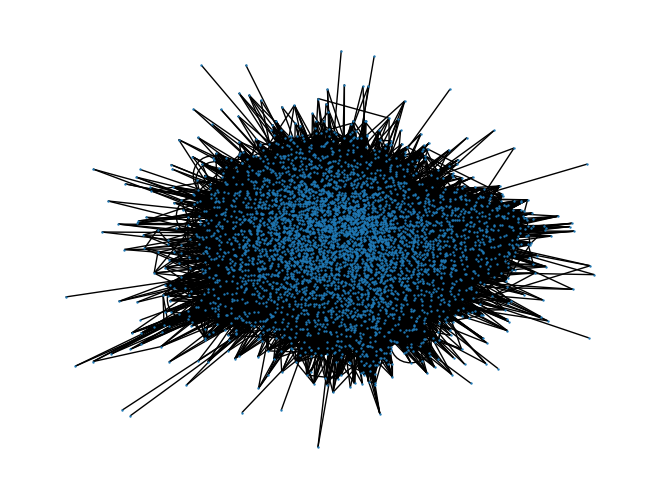

In [50]:
# Drawing the result
#! see again maybe there is a bug in graph creation
nx.draw(G, with_labels=False, node_size=0.5)
plt.draw()
plt.savefig("wiki_graph.pdf")


In [51]:
# Graph Analytics

def sort_dict_by_value(dict):
    return sorted(dict.items(), key=lambda x: x[1], reverse=True)

# Calculating the topN nodes with highest pagerank value
pagerankDict = nx.pagerank(G, alpha=0.9)
topN = 10
top_tuples = sort_dict_by_value(pagerankDict)[:topN]
for (key, value) in top_tuples:
    print(key, "->", value)

United_States -> 0.007353573504232259
United_Kingdom -> 0.004583764007138702
Europe -> 0.004356237512428051
France -> 0.004160104005185391
England -> 0.0036978311228364853
Germany -> 0.003349228550339175
World_War_II -> 0.0033466535501033698
Scientific_classification -> 0.002870713599200479
London -> 0.0028395840249095736
English_language -> 0.0027109720677327372


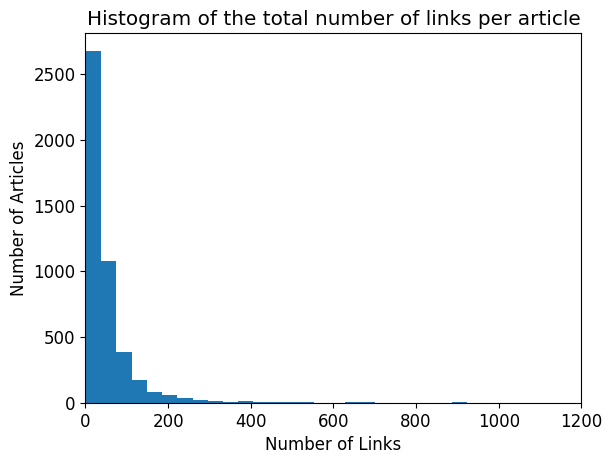

In [123]:
# Visualizing the number of links per article.

links_counts = wiki_graph["links_count"].values

plt.hist(links_counts, bins=50)
plt.title("Histogram of the total number of links per article")
plt.xlabel("Number of Links")
plt.ylabel("Number of Articles")
plt.xlim([0,1200])
plt.show()

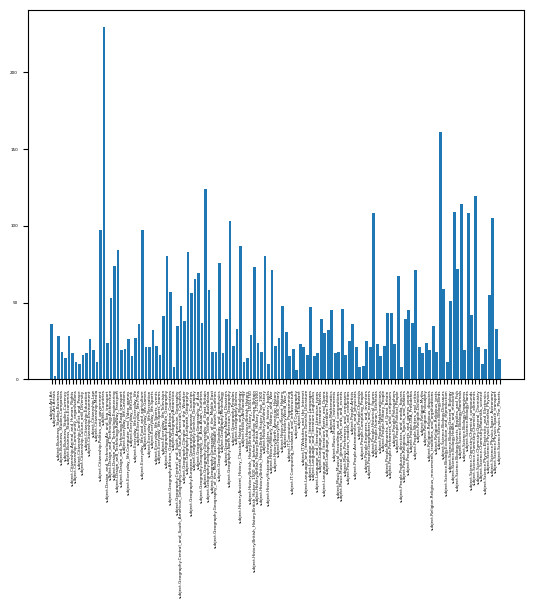

In [127]:
# Visualize categories

groups = categories.groupby("category").count()
#print(groups.head())

labels = list(groups.index)
values = list(groups["article"])
X_axis = np.arange(len(labels))

plt.rcParams["font.size"] = "3"

plt.xticks(rotation=90)
plt.bar(labels, values)
plt.show()

In [130]:
# Highest values of our categories

groups = categories.groupby("category").count()
values = list(groups["article"])
highest_cat = groups.sort_values(ascending=False, by=["article"])

print("Top-10 categories:")
highest_cat.head(10)



Top-10 categories:


,article
category,
subject.Countries,229
subject.Science.Biology.Birds,161
subject.Geography.Geography_of_Great_Britain,124
subject.Science.Chemistry.Chemical_elements,119
subject.Science.Biology.Mammals,114
subject.Science.Biology.Health_and_medicine,109
subject.Science.Biology.Plants,108
subject.People.Historical_figures,108
subject.Science.Physics.Space_Astronomy,105


### Link Position

For each article page, we scrape the html source code to retrieve the links and the paragraph number in which they are placed to create a dictionary of the form:

{"page_name" : {"link_page_name_1" : "paragraph_number_1" , link_page_name_2 : paragraph_number_2}}

In [106]:
import os
from bs4 import BeautifulSoup
import urllib.parse

path = "./data/graph/wpcd"
page_pos_dict = dict()
for article_name in wiki_graph["article"]:
    for root, dirs, files in os.walk(path):
        for name in files:
            if name == "{}.htm".format(article_name):
                try:
                    with open(os.path.join(root, name), encoding="utf-8") as file:
                        soup = BeautifulSoup(file, "lxml")
                    links_dict = dict()
                    for i, p in enumerate(soup.find_all("p")):
                        for link in p.find_all("a"):
                            link_title = link.get("title")
                            if (
                                link_title != None
                                and "jpg" not in link_title
                                and "png" not in link_title
                            ):
                                links_dict[
                                    urllib.parse.quote(link_title.replace(" ", "_"))
                                ] = i
                    page_pos_dict[article_name] = links_dict
                    # wiki_graph.loc[wiki_graph['article'] == article_name, 'links_par_position'] = links_dict
                except Exception:
                    print(
                        os.path.join(root, name)
                    )  # 5 pages cause an exception, because html cannot be decoded


In [107]:
import json

with open("page_pos_dict.json", "w") as outfile:
    json.dump(
        page_pos_dict, outfile
    )  # saving as json as the above cell takes more than 10 minutes to run


In [108]:
# shortcut to the above cell for dictionary
with open("page_pos_dict.json", "r") as file:
    page_pos_dict = json.load(file)


In [7]:
finished_paths = pd.read_csv(
    "./data/graph/paths_finished.tsv", sep="\t", skiprows=16, header=None
)


In [8]:
paths = []
for path in finished_paths[3]:
    if "<" not in path:  # removing backtracks
        path = path.split(";")
        for i in range(len(path) - 1):
            paths.append(path)


For each click of the players, we store the paragraph number of the chosen link and the average paragraph number of all the links in the page

In [28]:
chosen_pars = []
avg_pars = []
for path in paths:
    for i, article in enumerate(path):
        if i < len(path) - 1:
            source = article
            target = path[i + 1]
            if (
                target in page_pos_dict[source].keys()
            ):  # some links are missing from the dictionary, around 10%, these are the links that are not inside paragraph elements in html
                par_chosen = page_pos_dict[source][target]
                avg_par = sum(page_pos_dict[source].values()) / len(
                    page_pos_dict[source]
                )
                chosen_pars.append(par_chosen)
                avg_pars.append(avg_par)


Histograms comparing the average paragraphs of the links versus the paragraphs of the links chosen by the players

(array([3.22439e+05, 3.49209e+05, 1.92729e+05, 8.87130e+04, 2.14330e+04,
        5.10950e+04, 9.06000e+03, 8.07000e+02, 9.68700e+03, 2.40000e+01]),
 array([  0.        ,  18.10666667,  36.21333333,  54.32      ,
         72.42666667,  90.53333333, 108.64      , 126.74666667,
        144.85333333, 162.96      , 181.06666667]),
 <BarContainer object of 10 artists>)

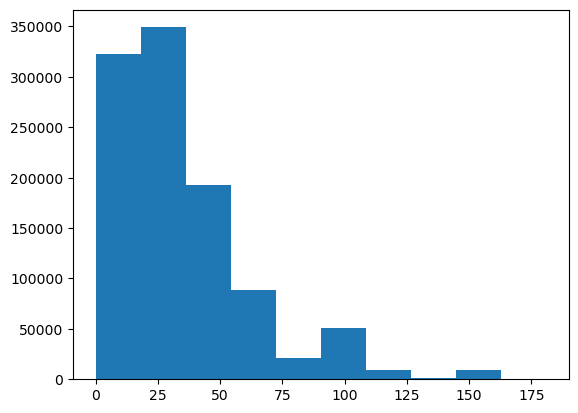

In [39]:
plt.hist(avg_pars)

(array([6.99144e+05, 2.15282e+05, 8.56970e+04, 2.88400e+04, 8.42600e+03,
        5.32500e+03, 7.33000e+02, 1.22800e+03, 5.08000e+02, 1.30000e+01]),
 array([  0.,  34.,  68., 102., 136., 170., 204., 238., 272., 306., 340.]),
 <BarContainer object of 10 artists>)

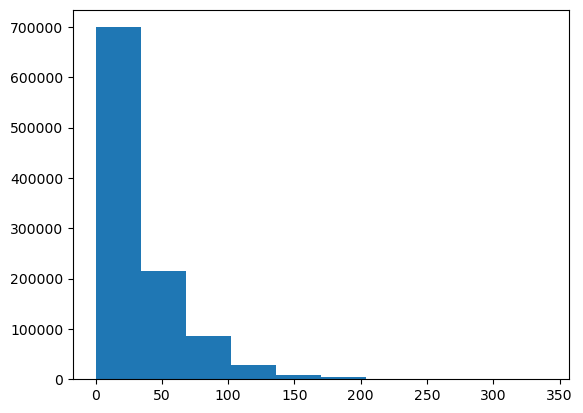

In [40]:
plt.hist(chosen_pars)

In [36]:
from scipy import stats

stats.ttest_ind(chosen_pars, avg_pars)


Ttest_indResult(statistic=-108.12216514780872, pvalue=0.0)

### Path analysis

In this section we perform analysis for the path data we have.

In [102]:
# Processing functions for the paths

def quantize_path(str_path):
    return str_path.split(";")


def get_start_node(list_path):
    return list_path[0]


def get_target_node(list_path):
    return list_path[len(list_path) - 1]


def get_back_click_num(list_path):
    return list_path.count("<")
    


In [103]:
# Load finished path data and do some preprocessing

paths_finished = pd.read_csv(
    "data/graph/paths_finished.tsv",
    skiprows=15,
    sep="\t",
    names=[
        "hashedIpAddress",
        "timestamp",
        "durationInSec",
        "path",
        "rating",
        "status",
        "start",
        "target",
    ],
)

# Labelling the paths as succesful
# paths_finished["status"] = ["Success" for x in range(len(paths_finished.index))]

# Processing the paths
paths_finished["path"] = paths_finished["path"].apply(quantize_path)
paths_finished["start"] = paths_finished["path"].apply(get_start_node)
paths_finished["target"] = paths_finished["path"].apply(get_target_node)
paths_finished["backclicks"] = paths_finished["path"].apply(get_back_click_num)

# Drop not needed columns
paths_finished = paths_finished.drop(columns=["hashedIpAddress", "timestamp"])

# Check
paths_finished.tail()


,durationInSec,path,rating,status,start,target,backclicks
51313,66,"[Yagan, Ancient_Egypt, Civilization]",NaN,NaN,Yagan,Civilization,0
51314,165,"[Yagan, Folklore, Brothers_Grimm, <, 19th_cent...",3.0,NaN,Yagan,Fiction,1
51315,228,"[Yagan, Australia, England, France, United_Sta...",NaN,NaN,Yagan,U.S._Open_%28tennis%29,0
51316,56,"[Yarralumla%2C_Australian_Capital_Territory, A...",1.0,NaN,Yarralumla%2C_Australian_Capital_Territory,Abraham_Lincoln,0
51317,30,"[Ziad_Jarrah, Germany, Jew]",NaN,NaN,Ziad_Jarrah,Jew,0


In [64]:
paths_unfinished = pd.read_csv(
    "data/graph/paths_unfinished.tsv",
    skiprows=19,
    sep="\t",
    names=["hashedIpAddress", "timestamp", "durationInSec", "path", "target", "type"],
)

paths_unfinished = paths_unfinished.drop(columns=["hashedIpAddress", "timestamp"])


paths_unfinished["path"] = paths_unfinished["path"].apply(quantize_path)
paths_unfinished["start"] = paths_unfinished["path"].apply(get_start_node)
paths_unfinished["backclicks"] = paths_unfinished["path"].apply(get_back_click_num)


# Dropping timeouts. Timeout might occur because the user was idle or wasnt playing tha game.
paths_unfinished = paths_unfinished[paths_unfinished["type"] != "timeout"]
#paths_unfinished["status"] = ["restart" for x in range(len(paths_unfinished.index))]


paths_unfinished.head()


,durationInSec,path,target,type,start,backclicks
1,49,[Paraguay],Mount_St._Helens,restart,Paraguay,0
5,175,"[4-2-0, United_States, Agriculture, Sugar, Aus...",Cane_Toad,restart,4-2-0,0
6,19,[Logic],Moon_landing,restart,Logic,0
9,8,[Niobium],Beeching_Axe,restart,Niobium,0
10,334,"[Saint_Kitts_and_Nevis, United_Kingdom, World_...",Sandy_Koufax,restart,Saint_Kitts_and_Nevis,0


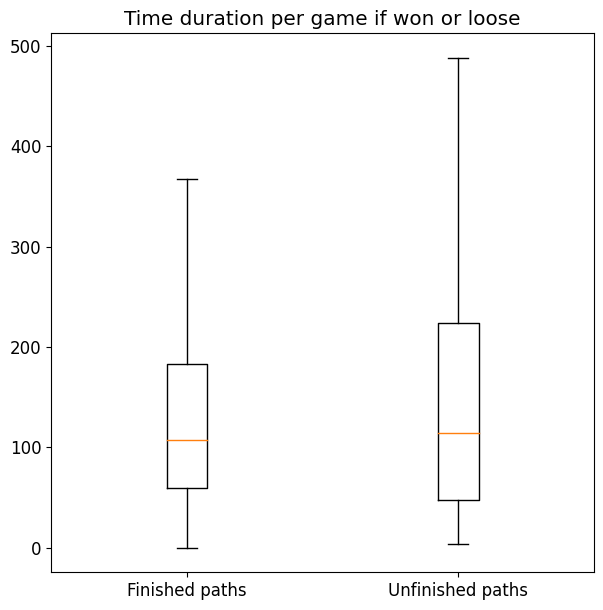

In [66]:
# Time duration analysis
duration_finish = paths_finished["durationInSec"].to_numpy()
duration_unfinish = paths_unfinished["durationInSec"].to_numpy()

duration = [duration_finish, duration_unfinish]

fig = plt.figure(figsize=(7, 7))  # Creating plot
plt.rcParams["font.size"] = "12"

plt.boxplot(duration, showfliers=False, labels=["Finished paths", "Unfinished paths"])
plt.title("Time duration per game if won or loose")
plt.show()


/var/folders/xk/r_3gyvbd2mzd6qzrql2zqt440000gn/T/ipykernel_27667/2755162881.py:27: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


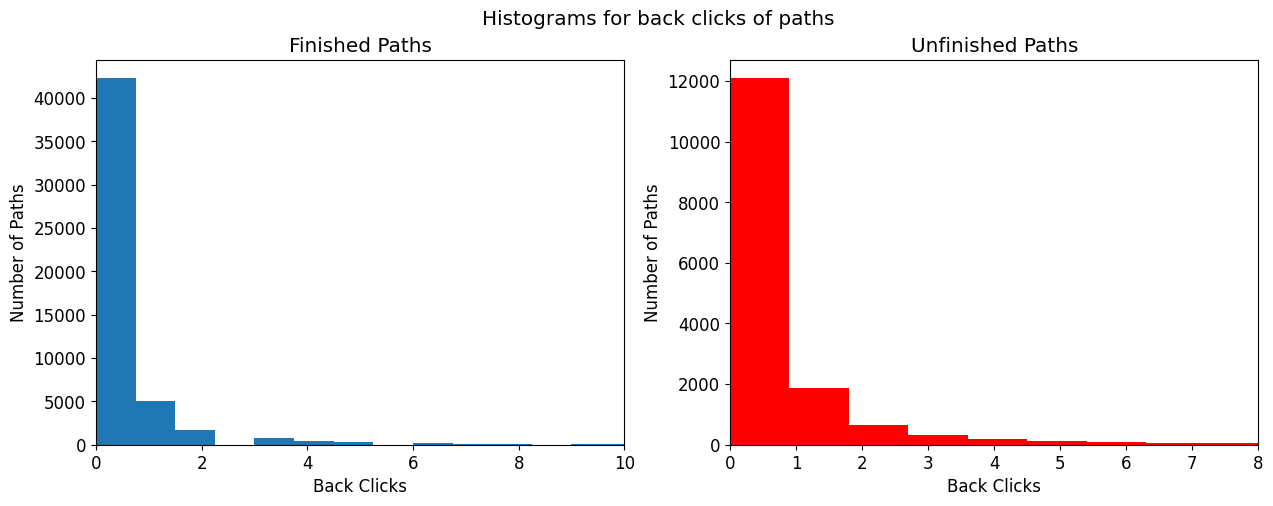

In [101]:
# Backclick analysis

backclicks_finished = paths_finished["backclicks"].to_numpy()
backclicks_unfinished = paths_unfinished["backclicks"].to_numpy()

fig, axs = plt.subplots(1, 2,figsize=(15, 5))
fig.suptitle("Histograms for back clicks of paths")

axs[0].hist(backclicks_finished,bins=60)
axs[0].set_xlim(0,10)
axs[0].set_title("Finished Paths")
axs[0].set(xlabel ="Back Clicks", ylabel = "Number of Paths")

axs[1].hist(backclicks_unfinished,bins=30, color="red")
axs[1].set_xlim(0,8)
axs[1].set_title("Unfinished Paths")
axs[1].set(xlabel ="Back Clicks", ylabel = "Number of Paths")

fig.show()

In [38]:
red_paths_finished = paths_finished.drop(columns=["rating"])
red_paths_unfinished = paths_unfinished.drop(columns=["type"])

paths = pd.concat([red_paths_finished, red_paths_unfinished], axis=0).drop(
    columns=["durationInSec"]
)

paths = paths.reindex(columns=["start", "target", "status", "path"])

paths.tail()


,start,target,status,path
24866,Wine,History_of_post-Soviet_Russia,Fail,"[Wine, Georgia_%28country%29, Russia]"
24867,Turks_and_Caicos_Islands,Iraq_War,Fail,"[Turks_and_Caicos_Islands, United_States, Iraq..."
24868,Franz_Kafka,Cholera,Fail,"[Franz_Kafka, Tuberculosis, World_Health_Organ..."
24869,Modern_history,Hollandic,Fail,[Modern_history]
24872,Mark_Antony,Feather,Fail,"[Mark_Antony, Rome, Tennis, Hawk-Eye, Computer]"
